# BB84 Protocol
In this document, we shall describe the BB84 protocol for secure quantum key distribution. The BB84 protocol exploits quantum behaviour to provide a secure way to exchange cryptographic keys over an insecure channel in the presence of an eavesdropper. We begin by importing the necessary components of qiskit. We also define the number of message qubits that we shall like to use.

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.circuit import Gate

In [2]:
# Define no. of message qubits
n = 10

## Objective
Alice and Bob can communicate with each other over an insecure channel with an eavesdropper Eve. To enable secure communications, they would like to exchange a secret key known only to them, so that they can encrypt subsequent messages with that key without the possibility of Eve being able to decipher them. However, the key exchange needs to be done through the insecure channel as well.

Thus, Alice needs to transfer a string of 0s and 1s to Bob without Eve being able to acquire the same information.

## Circuit Description & Analysis

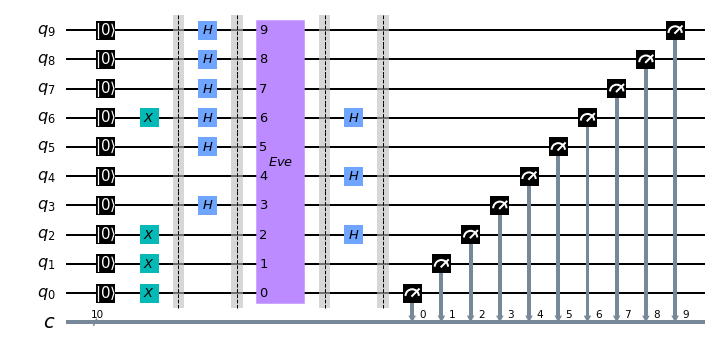

In [3]:
# Alice's end
alice_prepare = np.random.choice([0,1], size=(n,), p=[0.5, 0.5])
alice_hadamard = np.random.choice([0,1], size=(n,), p=[0.5, 0.5])
circ = QuantumCircuit(n, n)

# Preparation
circ.reset(range(n))
for i in range(n):
    if alice_prepare[i] == 1:
        circ.x(i)
circ.barrier()

# Hadamard Transform
for i in range(n):
    if alice_hadamard[i] == 1:
        circ.h(i)
circ.barrier()

# Eavesdropper
circ.append(Gate(name="$Eve$", num_qubits=n, params=[]), range(n))

# Bob's end
bob_hadamard = np.random.choice([0,1], size=(n,), p=[0.5, 0.5])
circ.barrier()

# Hadamard Transform
for i in range(n):
    if bob_hadamard[i] == 1:
        circ.h(i)
circ.barrier()

# Measurement
circ.measure(range(n), range(n))
circ.draw('mpl', reverse_bits=True, scale=0.45)

### Alice - Barrier 1 & 2
First, Alice prepares n qubits randomly in the state $|0\rangle$ or $|1\rangle$. Then, she randomly applies a Hadamard Transform to about half of the qubits.
1. The $\textbf{alice_prepare}$ array in the code maintains the list of initially prepared states in the computational basis ($|0\rangle$ or $|1\rangle$).
2. The $\textbf{alice_hadamard}$ array in the code records whether or not Alice applies the Hadamard Transform to the qubit in a given position, where a 1 indicates that the H Transform is applied to the corresponding qubit.

### Eve - Barrier 3
Eve represents the eavesdropper. For now, we shall assume that the eavesdropper is not attempting an infiltration. We thus, model Eve as an identity operator. We shall describe below what happens if Eve tries to measure the transmitted qubits.

### Bob - Barrier 4 & Meassurement
Bob now randomly applies a series of Hadamard Transforms to the received qubits. He then measures all qubits.
1. The $\textbf{bob_hadamard}$ in the code records whether or not Bob applies the Hadamard Transform to the qubit in a given position, where a 1 indicates that the H Transform is applied to the corresponding qubit.
2. The $\textbf{bob_measure}$ array (not shown in above code) stores the results of his measurement.

### Post Measurement Analysis
Bob and Alice now share the $\textbf{bob_hadamard}$ and $\textbf{alice_hadamard}$ arrays with each other over an insecure classical channel. Obviously, Eve acquires access to these arrays as well. However, note that Eve cannot acquire access to these arrays before Bob performs his meaurement.

1. For a given qubit $q_i$, we either have $\textbf{bob_hadamard[i]} = \textbf{alice_hadamard[i]}$ or $\textbf{bob_hadamard[i]} \neq \textbf{alice_hadamard[i]}$
2. In both of the above cases, Eve may or may not be present.

#### Case 1A: $\textbf{bob_hadamard[i]} \neq \textbf{alice_hadamard[i]}$ (Eve - absent).
In this case, a single $H$ Transform acts on $q_i$.
$$|0\rangle_{Alice} \rightarrow \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right)_{Bob}$$
$$|1\rangle_{Alice} \rightarrow \left(\frac{|0\rangle - |1\rangle}{\sqrt{2}}\right)_{Bob}$$
$$\quad$$
So, when Bob measures $q_i$, he gets a random $0$ or $1$. The qubit $q_i$ is then completely useless and should be discarded.

#### Case 1B: $\textbf{bob_hadamard[i]} = \textbf{alice_hadamard[i]}$ (Eve - absent).
In this case, since $H^2=I$, we have,
$$|0\rangle_{Alice} \rightarrow |0\rangle_{Bob}$$
$$|1\rangle_{Alice} \rightarrow |1\rangle_{Bob}$$
$$\quad$$
So, when Bob measures $q_i$, he gets $\textbf{bob_measure[i]} = \textbf{alice_prepare[i]}$. The qubit $q_i$ is then marked as valid and Alice and Bob can now use the measured value of $q_i$ as part of their secret key.

#### Case 2A: $\textbf{bob_hadamard[i]} \neq \textbf{alice_hadamard[i]}$ (Eve - present).
There is nothing for Eve to steal here, since the qubit $q_i$ is discarded anyway.

#### Case 2B: $\textbf{bob_hadamard[i]} = \textbf{alice_hadamard[i]}$ (Eve - present).
Notice that,
$$|0\rangle_{Alice} \rightarrow \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right)_{Eve} \rightarrow |0\rangle_{Bob};
\quad|1\rangle_{Alice} \rightarrow \left(\frac{|0\rangle - |1\rangle}{\sqrt{2}}\right)_{Eve} \rightarrow |1\rangle_{Bob};
\qquad if\quad h = 1$$
$$\quad$$
$$|0\rangle_{Alice} \rightarrow |0\rangle_{Eve} \rightarrow |0\rangle_{Bob};
\quad|1\rangle_{Alice} \rightarrow |1\rangle_{Eve} \rightarrow |1\rangle_{Bob};
\qquad if\quad h = 0$$
$$\quad$$
where $h = \textbf{bob_hadamard[i]} = \textbf{alice_hadamard[i]}$. Unfortunately for Eve, she does not have access to the $\textbf{bob_hadamard}$ and $\textbf{alice_hadamard}$ arrays prior to Bob's measurement and is therefore, totally ignorant of what state she has in hand. Thus, the best she can do is randomly apply hadamard transforms and measure. However, doing so would project the qubits to either $|0\rangle$ or $|1\rangle$ and subsequently, when Bob measures $q_i$, he may get $\textbf{bob_measure[i]} \neq \textbf{alice_prepare[i]}$. Subsequently, Alice & Bob can verify channel integrity by comparing some of their validated qubits. If a breach is found, the process is repeated over a new channel.

Notice however, that to verify channel integrity, Alice and Bob will need to compare some of their validated qubits over an insecure channel and thus, sacrifice these qubits. For a large number of transferred qubits however, this is not a problem.

## Qiskit Implementation
We shall simulate the BB84 protocol using Qiskit's QASM Simulator. We first model Eve as an identity operator (Eve is absent) and demonstrate the process of secret key extraction by Alice and Bob. We then add in Eve and have her attempt a measurement of the qubits being transmitted. Thereafter, we demonstrate breach detection via the BB84 protocol.

### Eavesdropper Absent

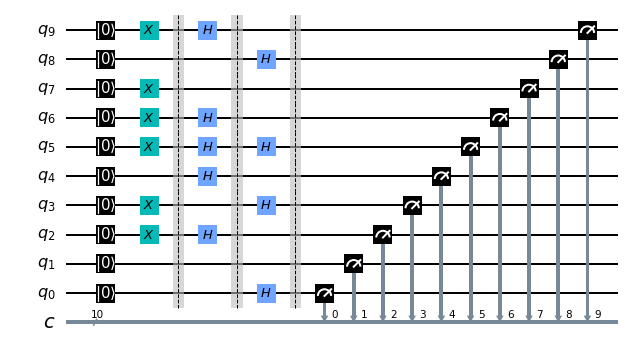

In [4]:
# Alice's end
alice_prepare = np.random.choice([0,1], size=(n,), p=[0.5, 0.5])
alice_hadamard = np.random.choice([0,1], size=(n,), p=[0.5, 0.5])
circ = QuantumCircuit(n, n)

# Preparation
circ.reset(range(n))
for i in range(n):
    if alice_prepare[i] == 1:
        circ.x(i)
circ.barrier()

# Hadamard Transform
for i in range(n):
    if alice_hadamard[i] == 1:
        circ.h(i)
circ.barrier()

# Bob's end
bob_hadamard = np.random.choice([0,1], size=(n,), p=[0.5, 0.5])

# Hadamard Transform
for i in range(n):
    if bob_hadamard[i] == 1:
        circ.h(i)
circ.barrier()

# Measurement
circ.measure(range(n), range(n))
circ.draw('mpl', reverse_bits=True, scale=0.45)

In [ ]:
# Execute Circuit
backend = Aer.get_backend('qasm_simulator')
job = execute(circ, backend, shots=1)
counts = job.result().get_counts(circ)
bob_measure = list(counts.keys())[0][::-1]

# Print Data
print("".join(["Alice Prepared:          ","".join([str(i) for i in alice_prepare])]))
print("".join(["Alice H Transforms:      ","".join([str(i) for i in alice_hadamard])]))
print("".join(["Bob H Transforms:        ","".join([str(i) for i in bob_hadamard])]))
print("".join(["Bob Measurements:        ", bob_measure]))

# Extract Key
alice_key = []
bob_key = []
for i in range(n):
    if alice_hadamard[i]==bob_hadamard[i]:
        alice_key.append(int(alice_prepare[i]))
        bob_key.append(int(bob_measure[i]))
        
# Print Keys
print("".join(["Alice extracts key as:   ","".join([str(i) for i in alice_key])]))
print("".join(["Bob extracts key as:     ","".join([str(i) for i in bob_key])]))

Alice Prepared:          0011011101
Alice H Transforms:      0010111001
Bob H Transforms:        1001010010
Bob Measurements:        1010111111
Alice extracts key as:   011
Bob extracts key as:     011


Both Alice & Bob compare the entries of the $\textbf{alice_hadamard}$ and $\textbf{bob_hadamard}$ arrays. For each entry which are found to be equal, Alice appends the corresponding bit from the $\textbf{alice_prepare}$ array to her version of the key and bob does the same from the $\textbf{bob_measure}$ array. Notice that both Bob and Alice extracts the same secret key (as should be).

### Eavesdropper Present

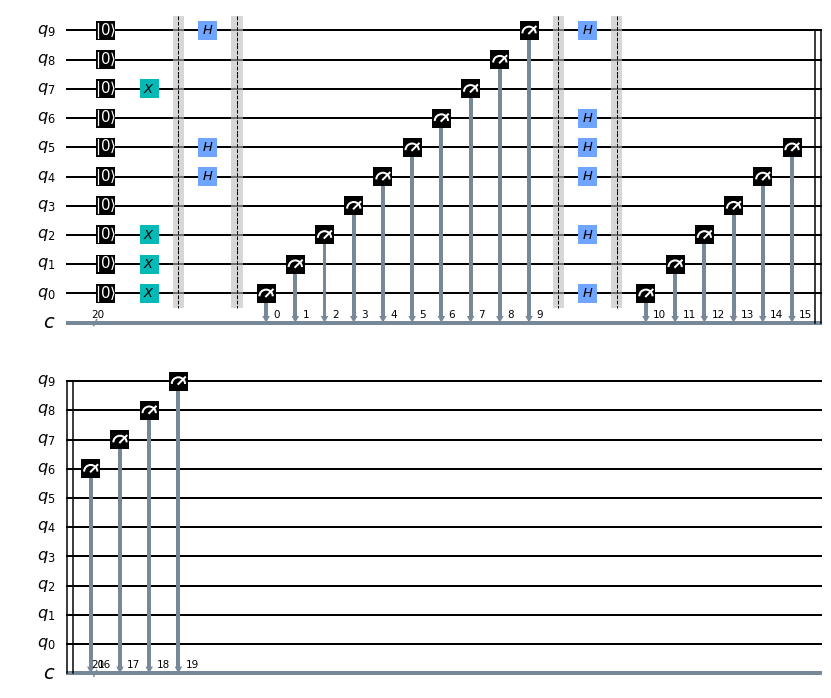

In [6]:
# Alice's end
alice_prepare = np.random.choice([0,1], size=(n,), p=[0.5, 0.5])
alice_hadamard = np.random.choice([0,1], size=(n,), p=[0.5, 0.5])
circ = QuantumCircuit(n, 2*n)

# Preparation
circ.reset(range(n))
for i in range(n):
    if alice_prepare[i] == 1:
        circ.x(i)
circ.barrier()

# Hadamard Transform
for i in range(n):
    if alice_hadamard[i] == 1:
        circ.h(i)
circ.barrier()

# Eavesdropper
circ.measure(range(n), range(n))

# Bob's end
bob_hadamard = np.random.choice([0,1], size=(n,), p=[0.5, 0.5])
circ.barrier()

# Hadamard Transform
for i in range(n):
    if bob_hadamard[i] == 1:
        circ.h(i)
circ.barrier()

# Measurement
circ.measure(range(n), range(n,2*n))
circ.draw('mpl', reverse_bits=True, scale=0.45)

In [ ]:
# Execute Circuit
backend = Aer.get_backend('qasm_simulator')
job = execute(circ, backend, shots=1)
counts = job.result().get_counts(circ)
measure_data = list(counts.keys())[0][::-1]
eve_measure = measure_data[0:n]
bob_measure = measure_data[n:2*n]

# Print Data
print("".join(["Alice Prepared:          ","".join([str(i) for i in alice_prepare])]))
print("".join(["Alice H Transforms:      ","".join([str(i) for i in alice_hadamard])]))
print("".join(["Eve Measurements:        ", eve_measure]))
print("".join(["Bob H Transforms:        ","".join([str(i) for i in bob_hadamard])]))
print("".join(["Bob Measurements:        ", bob_measure]))

# Extract Key
alice_key = []
bob_key = []
for i in range(n):
    if alice_hadamard[i]==bob_hadamard[i]:
        alice_key.append(int(alice_prepare[i]))
        bob_key.append(int(bob_measure[i]))
        
# Print Keys
print("".join(["Alice extracts key as:   ","".join([str(i) for i in alice_key])]))
print("".join(["Bob extracts key as:     ","".join([str(i) for i in bob_key])]))

Alice Prepared:          1110000100
Alice H Transforms:      0000110001
Eve Measurements:        1110000101
Bob H Transforms:        1010111001
Bob Measurements:        1100100101
Alice extracts key as:   1000100
Bob extracts key as:     1010101


Notice that Alice and Bob now measure different keys, which they can verify to identify the breach. At the same time, Eve essentially obtains a random and completely useless string of 0s and 1s.


## Remarks
Note that in this case, the keys obtained are not too useful, essentially due to the small number of qubits used. Also, for the same reason, there remains a non negligible probability that the two keys are in fact the same and the breach is not detected. In any case, Eve obtains no useful information and the above problems are easily solved when a large number of qubits are employed.

## References
1. Mermin, N. D. (2007). Quantum computer science: An introduction. Cambridge University Press.
2. Nielsen, M. A., & Chuang, I. L. (2010). Quantum computation and quantum information: 10th anniversary edition. Cambridge University Press.
3. Qiskit documentation — Qiskit 0.19.3 documentation. (n.d.). Qiskit. https://qiskit.org/documentation/